![Logo](logo.jpg)

# Next-Token Prediction (Hugging Face Transformers)

In [4]:
# Task 3: Next-Token Prediction (Hugging Face Transformers)
#!pip install transformers
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

# Load pretrained GPT-2 model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("gpt2")
model = AutoModelForCausalLM.from_pretrained("gpt2")
#generator = pipeline("text-generation", model="gpt2")
#print(generator("Once upon a time,", max_new_tokens=20)[0]['generated_text'])
prompt = "Once upon a time, there were"
inputs = tokenizer(prompt, return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs)
logits = outputs.logits  # (1, seq_len, vocab_size)

# Focus on next-token logits for the last position of the prompt
next_token_logits = logits[0, -1]          # (vocab_size)
probs = torch.softmax(next_token_logits, dim=-1)

# TODO: Find the top 5 tokens and their probabilities
topk = torch.topk(probs, k=5)
top_tokens = [tokenizer.decode([idx]) for idx in topk.indices]
print("Top-5 predicted tokens:", top_tokens)
print("Probabilities:", topk.values.tolist())


Top-5 predicted tokens: [' two', ' many', ' no', ' three', ' a']
Probabilities: [0.07891711592674255, 0.06224452331662178, 0.055981967598199844, 0.03470434620976448, 0.03445740416646004]


# Modifying Logits in Inference

In [5]:
# Task 4, Part B: Modifying Logits in Inference
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("gpt2")
model = AutoModelForCausalLM.from_pretrained("gpt2")

prompt = "He opened the door and saw a" # prompt = "The quick brown"
inputs = tokenizer(prompt, return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs)
logits = outputs.logits  # (1, seq_len, vocab_size)

# Identify the ID for the token " fox" (note the space, since GPT-2 is byte-based)
forbidden_token = tokenizer.encode(" man")[0]  # likely corresponds to " fox"
# Set its logit to -inf to ban it
logits[0, -1, forbidden_token] = float('-inf')
probs = torch.softmax(logits[0, -1], dim=-1)

# Compare top predictions before and after banning
with torch.no_grad():
    orig_logits = model(**inputs).logits
orig_probs = torch.softmax(orig_logits[0, -1], dim=-1)
orig_top5 = torch.topk(orig_probs, 20)
new_top5 = torch.topk(probs, 20)
print("Original top tokens:", [tokenizer.decode([i]) for i in orig_top5.indices])
print("Modified top tokens:", [tokenizer.decode([i]) for i in new_top5.indices])


Original top tokens: [' man', ' young', ' woman', ' large', ' group', ' black', ' huge', ' white', ' girl', ' small', ' couple', ' tall', ' pair', ' figure', ' few', ' boy', ' bunch', ' big', ' dark', ' dozen']
Modified top tokens: [' young', ' woman', ' large', ' group', ' black', ' huge', ' white', ' girl', ' small', ' couple', ' tall', ' pair', ' figure', ' few', ' boy', ' bunch', ' big', ' dark', ' dozen', ' little']


#  Inspecting Attention Heads

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


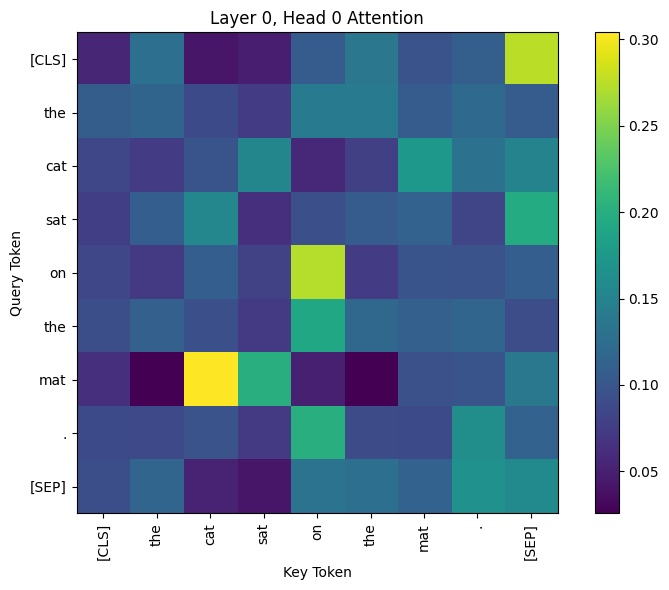

In [6]:
# Task 4, Part A: Inspecting Attention Heads
#!pip install transformers
import matplotlib.pyplot as plt
from transformers import AutoModel, AutoTokenizer

# Load pretrained BERT for attention visualization
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased", output_attentions=True)

text = "The cat sat on the mat."
inputs = tokenizer(text, return_tensors="pt")
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

outputs = model(**inputs)
attentions = outputs.attentions  # tuple of (layer, batch, heads, seq_len, seq_len)

# TODO: Select a specific layer and head to examine
layer_idx = 0
head_idx = 0
attn_matrix = attentions[layer_idx][0, head_idx].detach().numpy()  # (seq_len, seq_len)
# Ploting heatmap with tokens
plt.figure(figsize=(8, 6))
plt.imshow(attn_matrix, cmap='viridis')
plt.title(f"Layer {layer_idx}, Head {head_idx} Attention")

plt.xticks(ticks=range(len(tokens)), labels=tokens, rotation=90)
plt.yticks(ticks=range(len(tokens)), labels=tokens)

plt.xlabel("Key Token")
plt.ylabel("Query Token")
plt.colorbar()
plt.tight_layout()
plt.show()

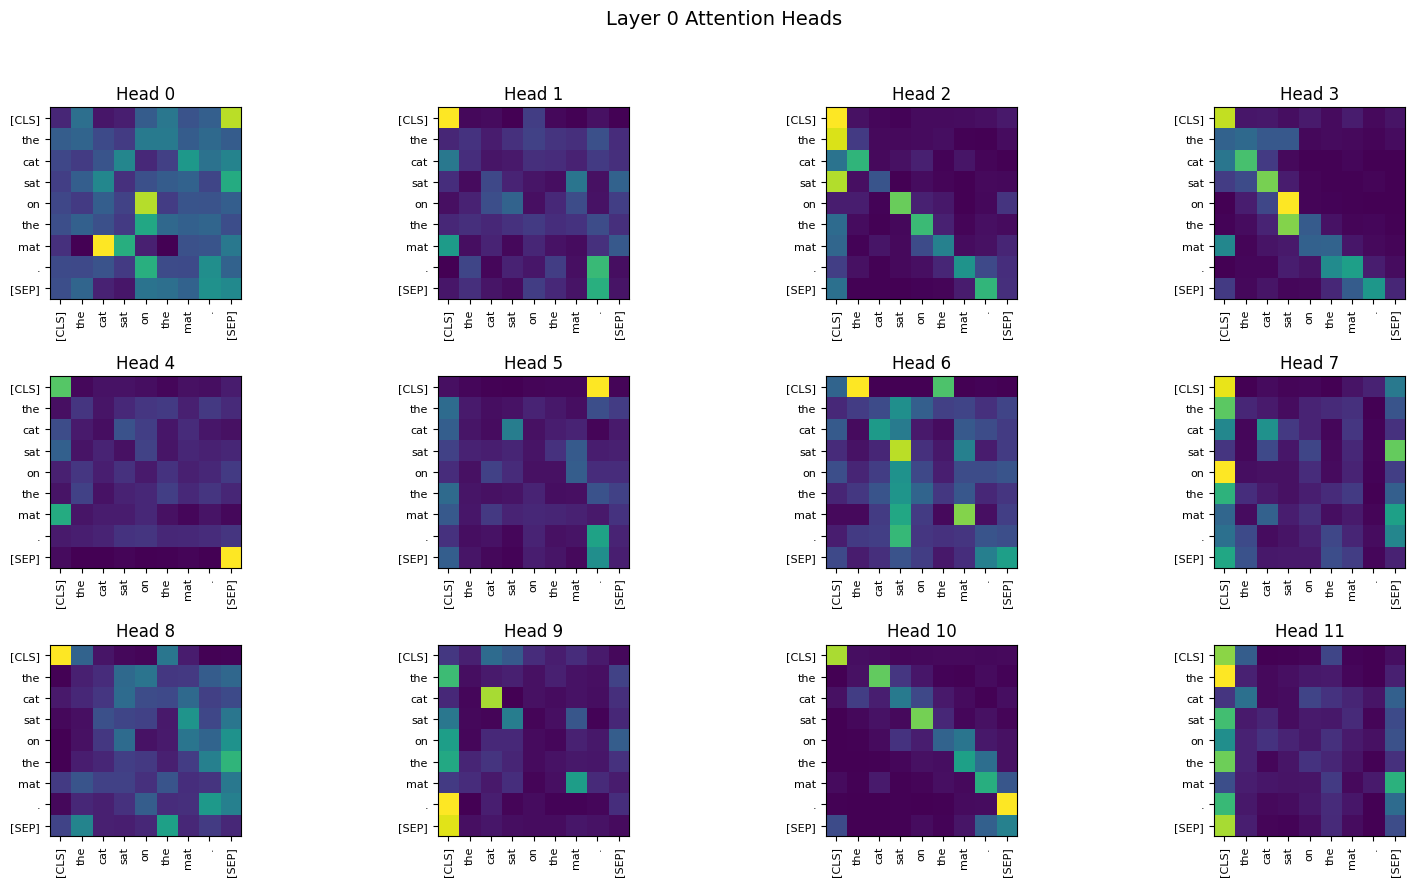

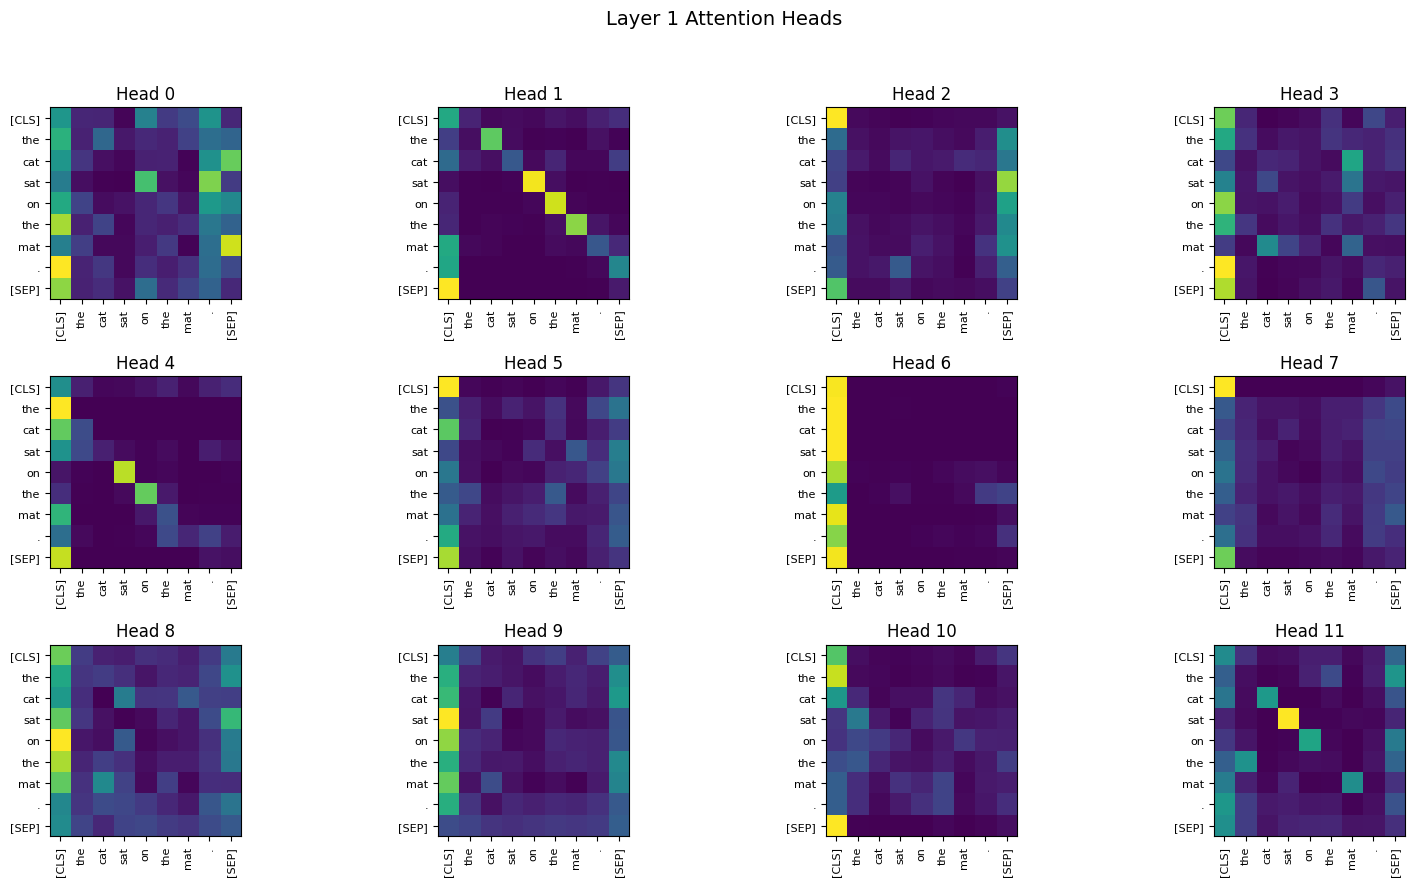

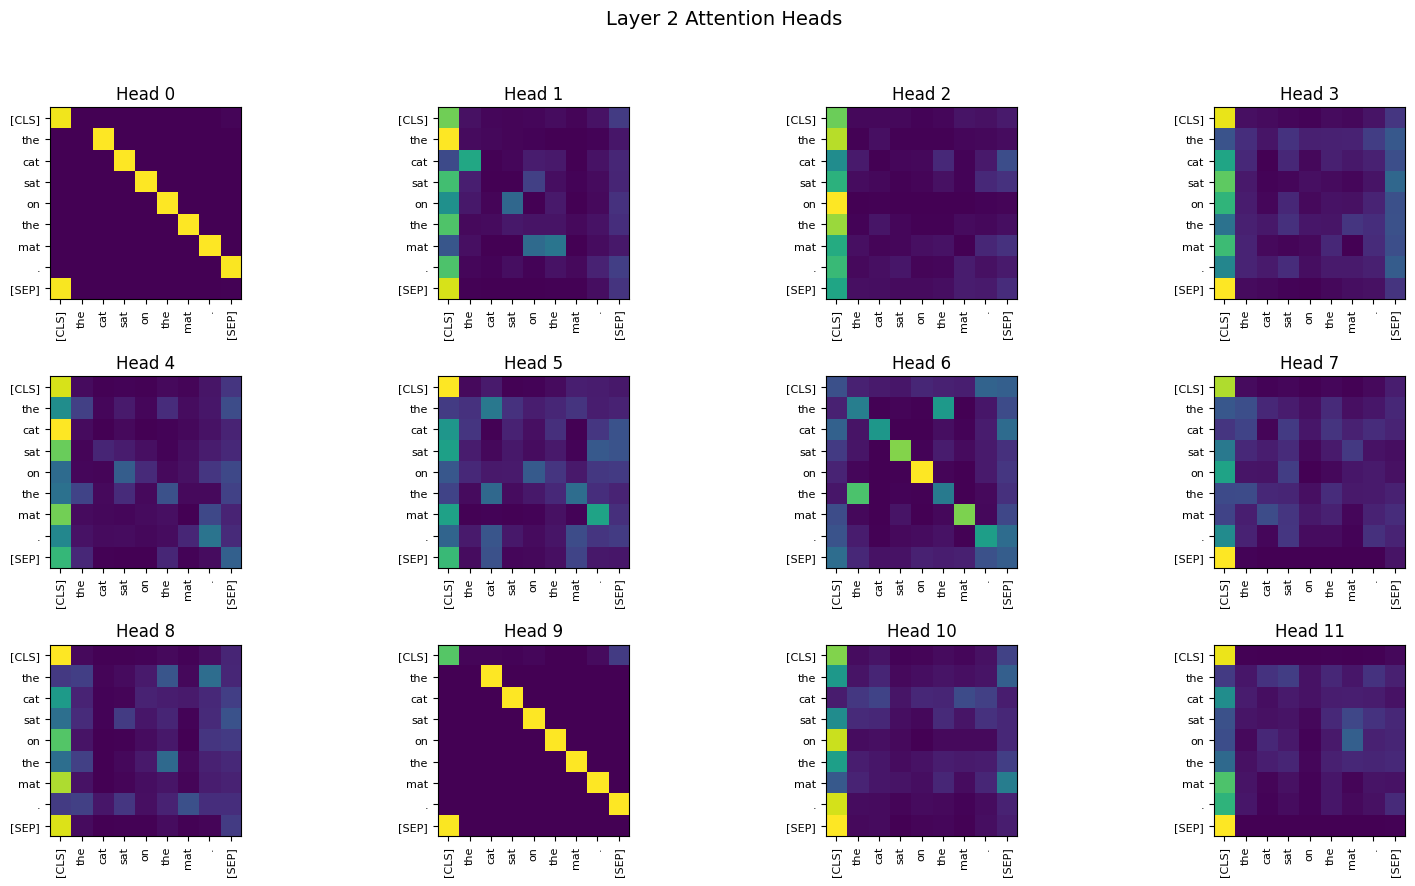

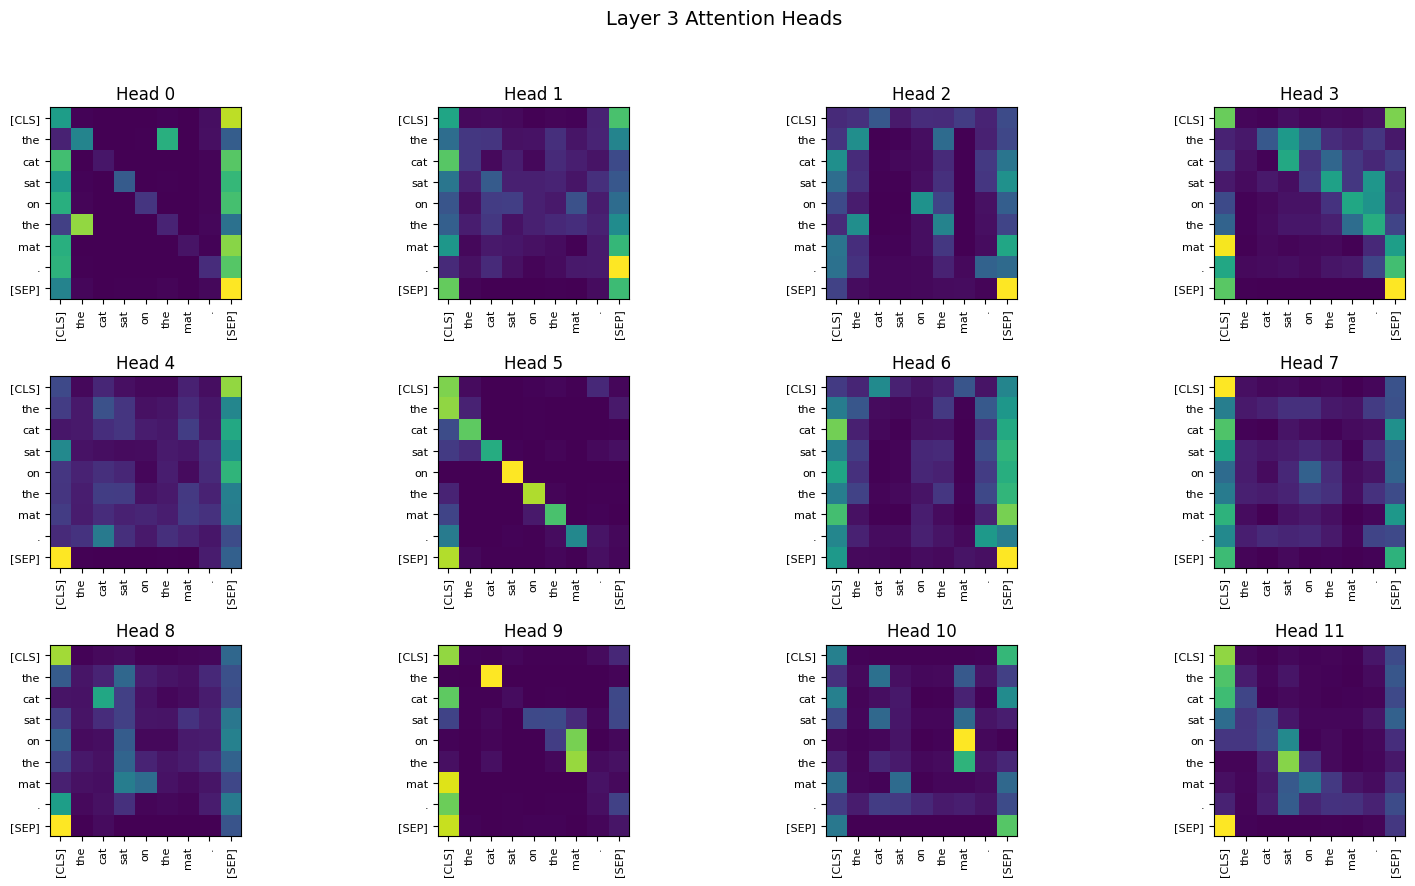

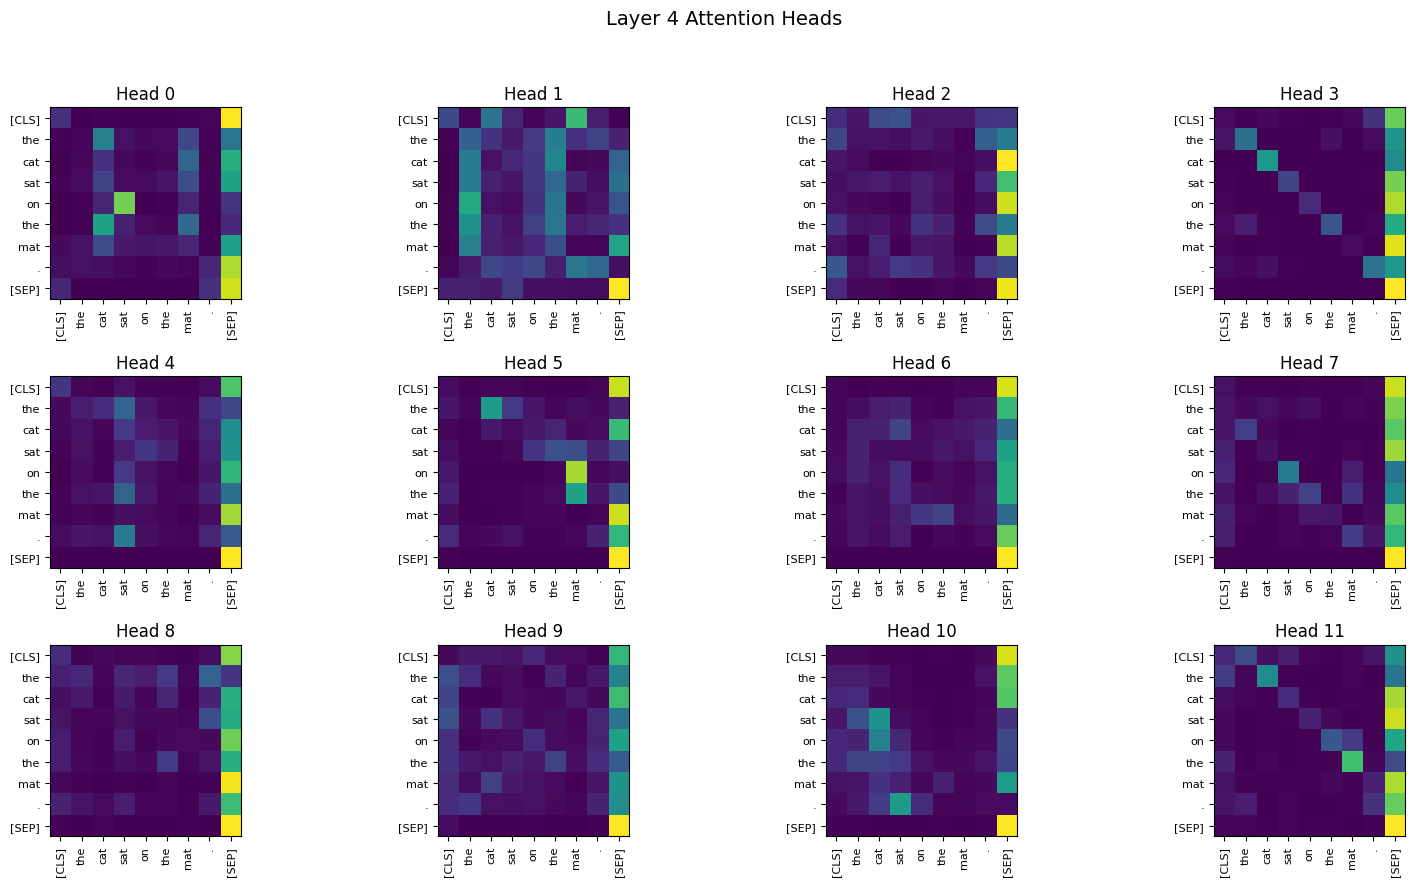

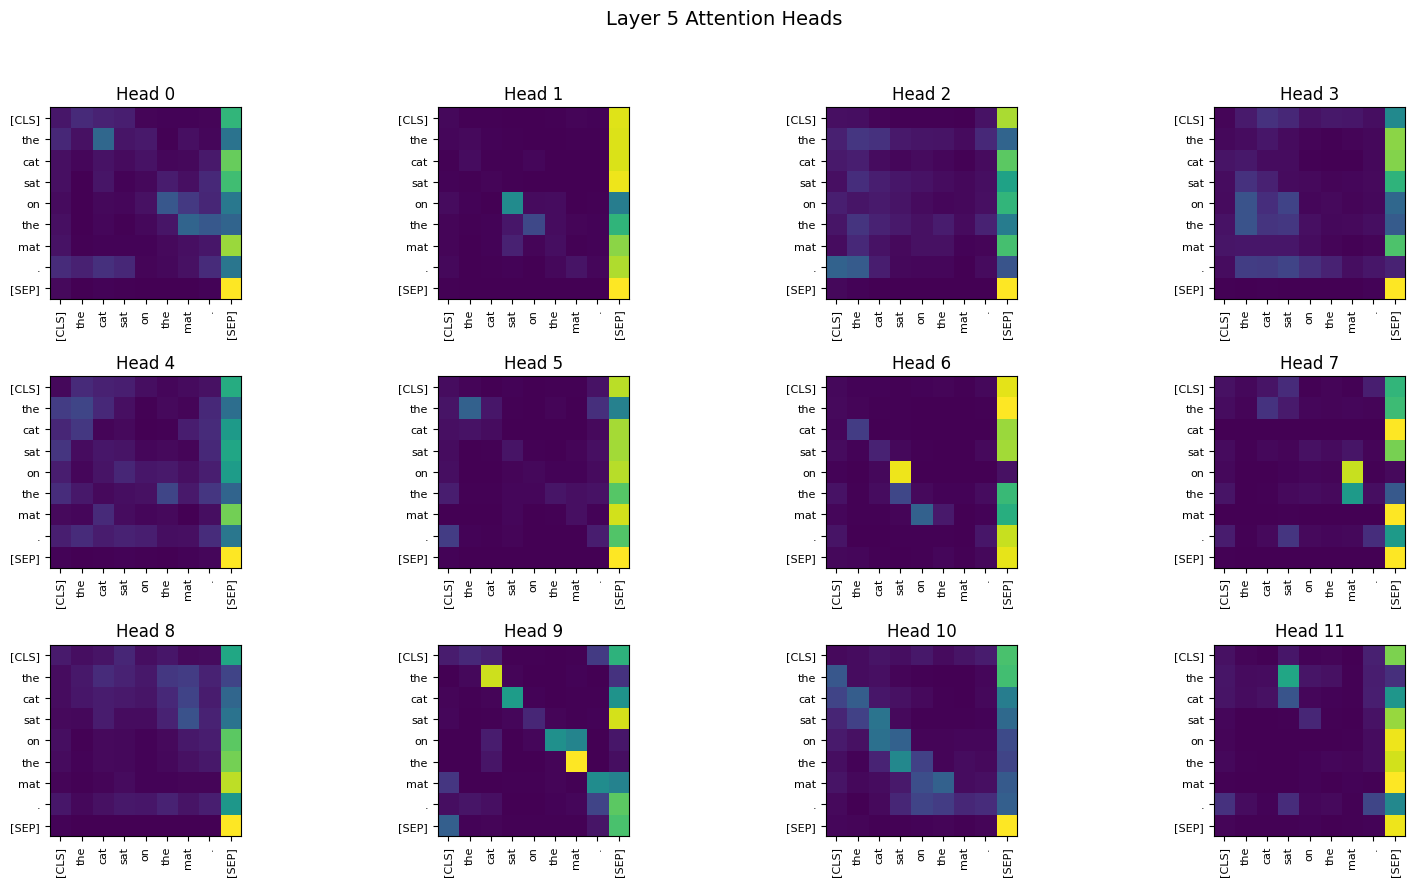

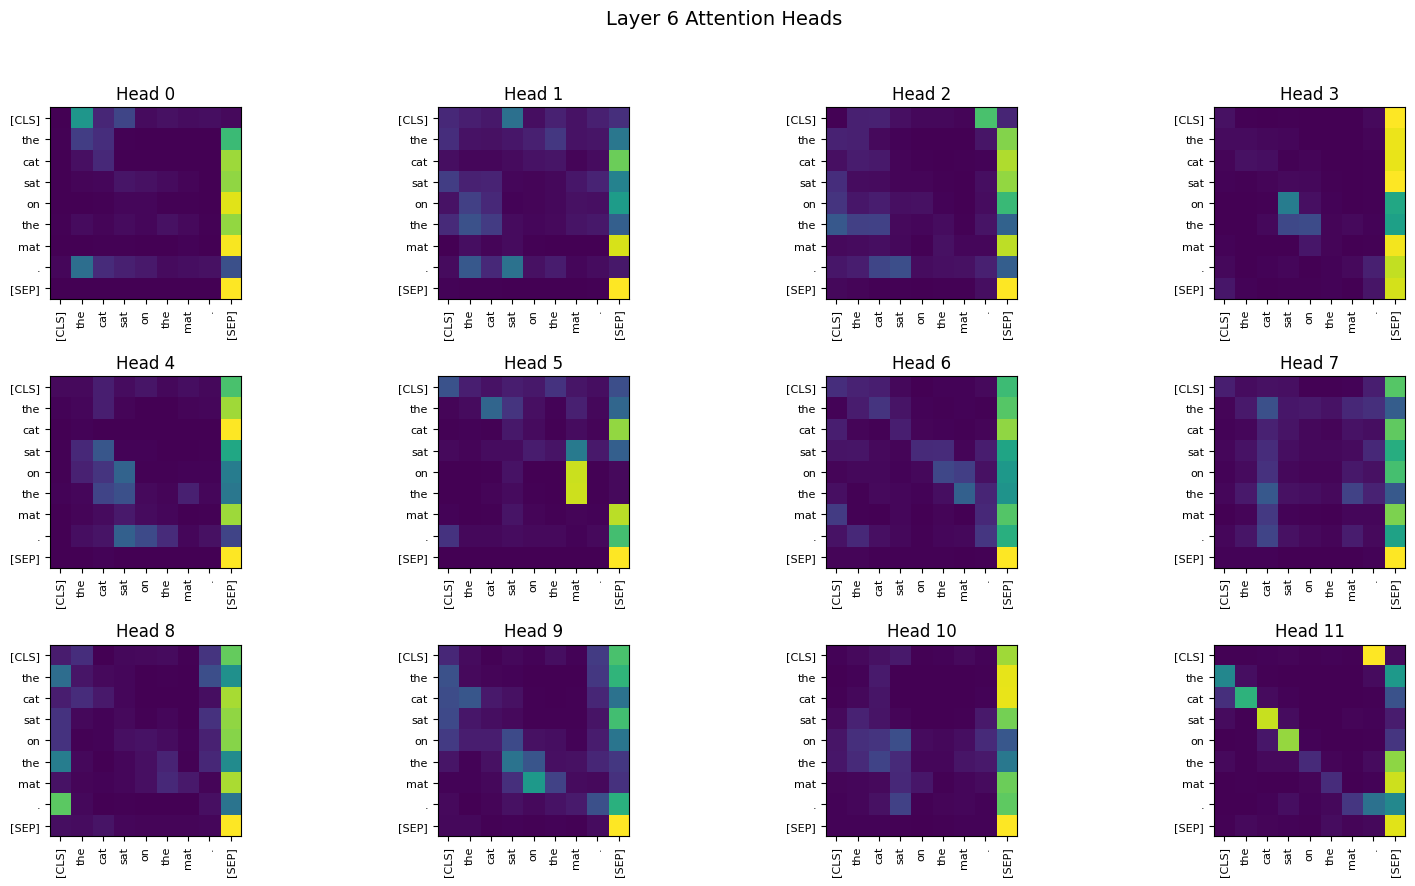

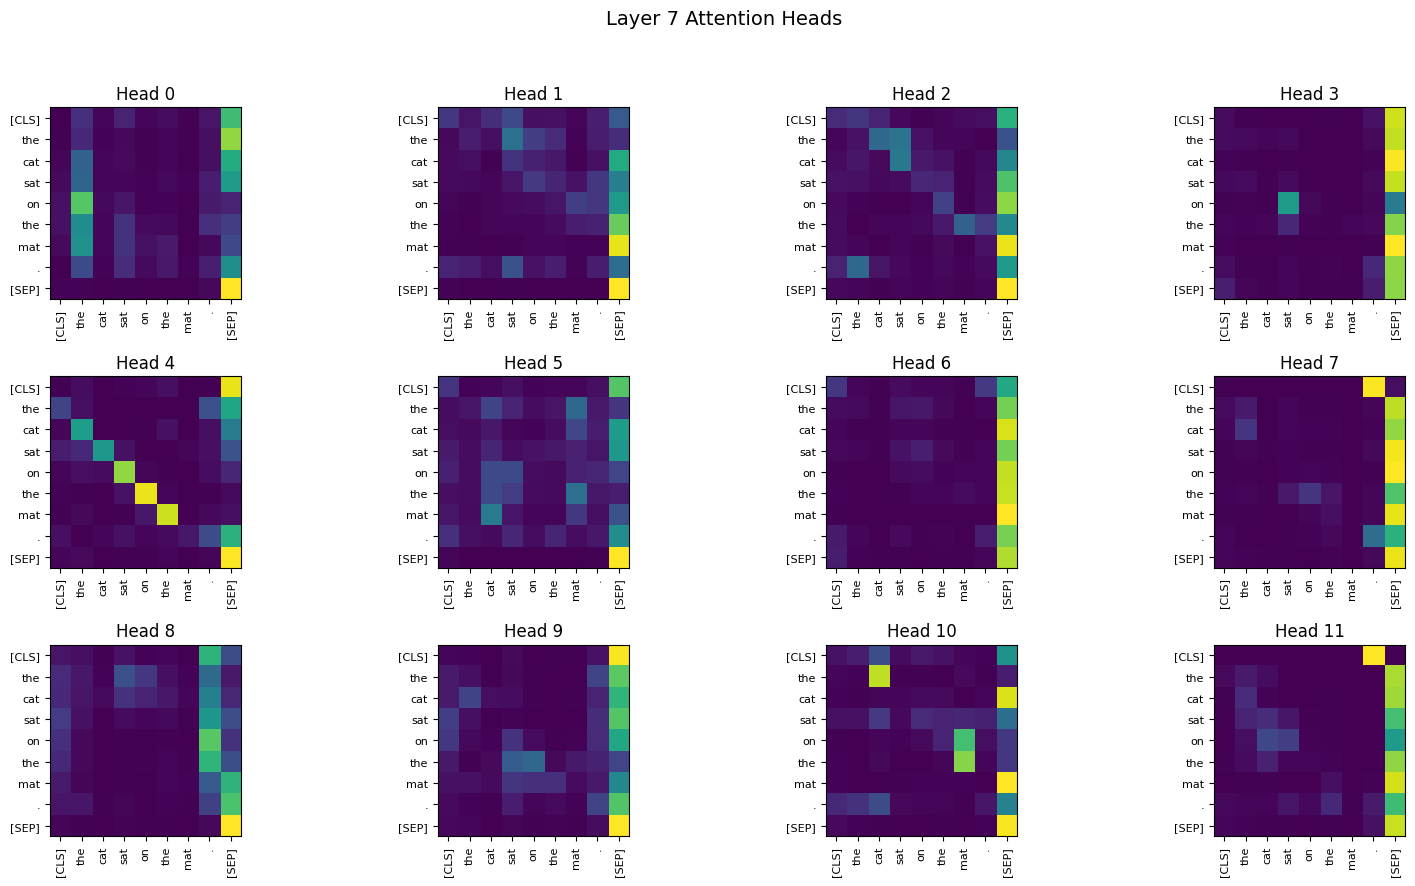

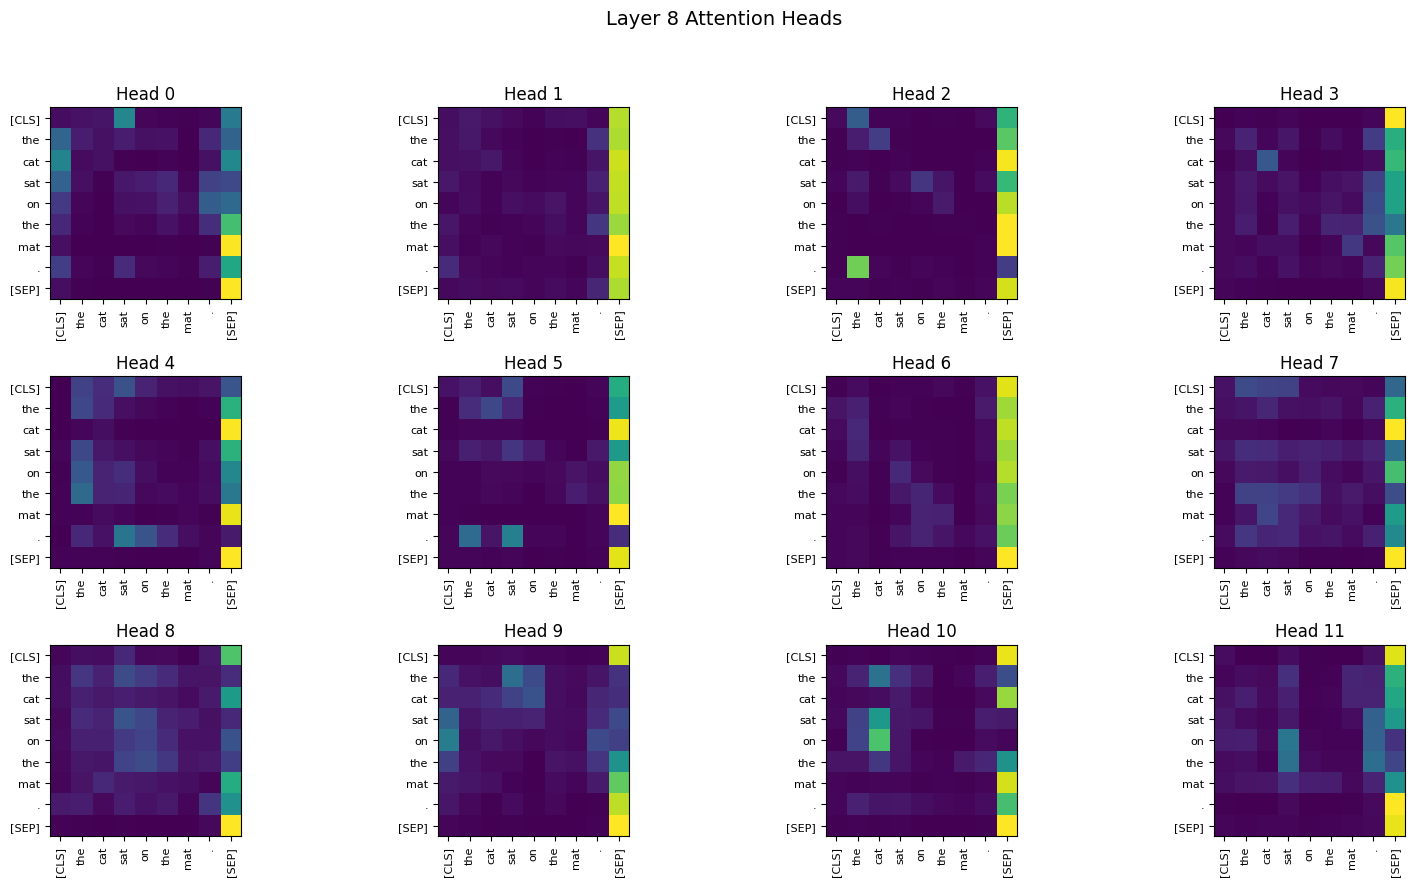

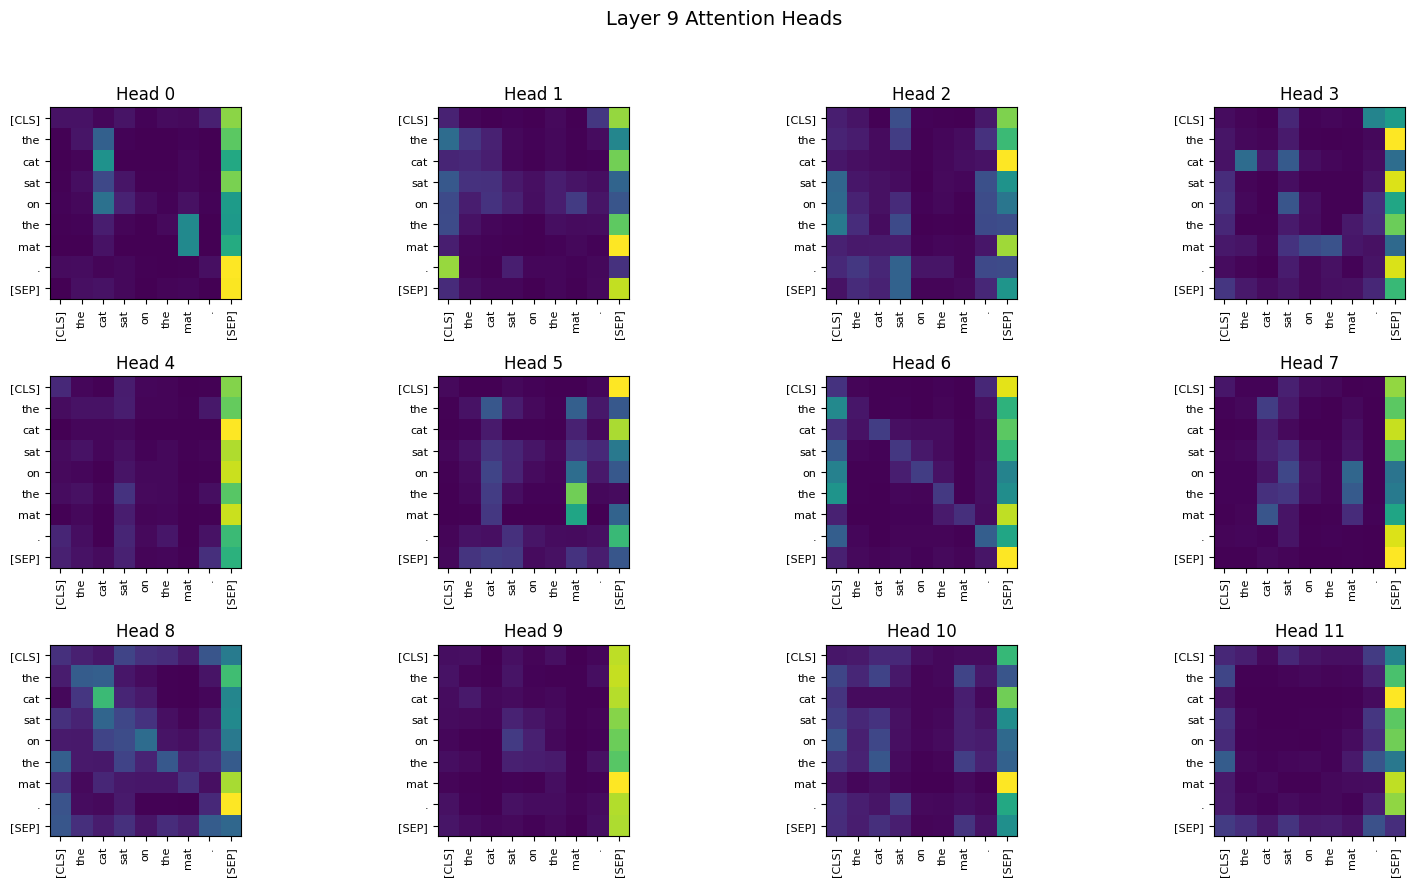

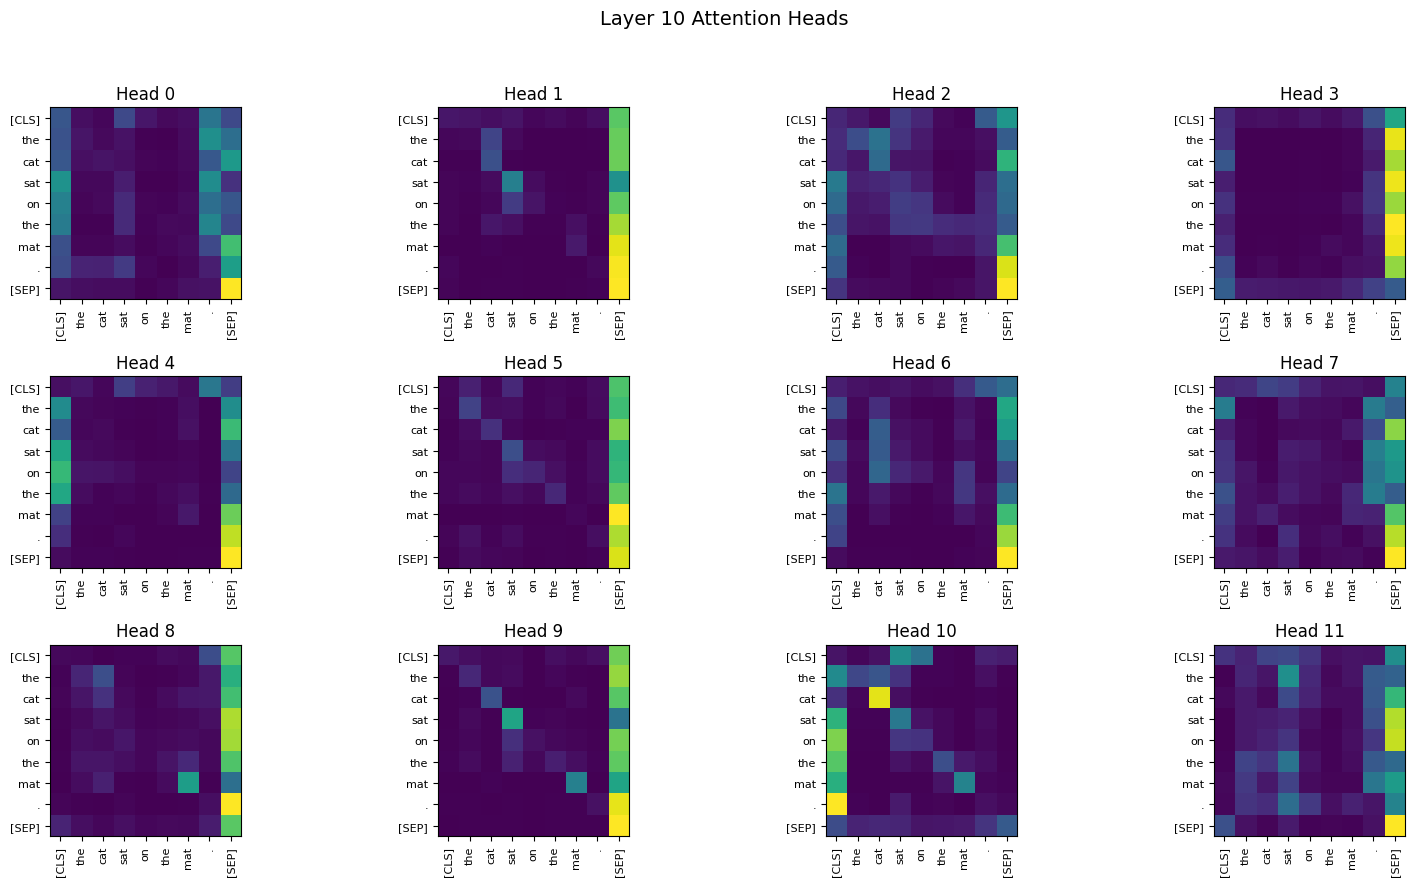

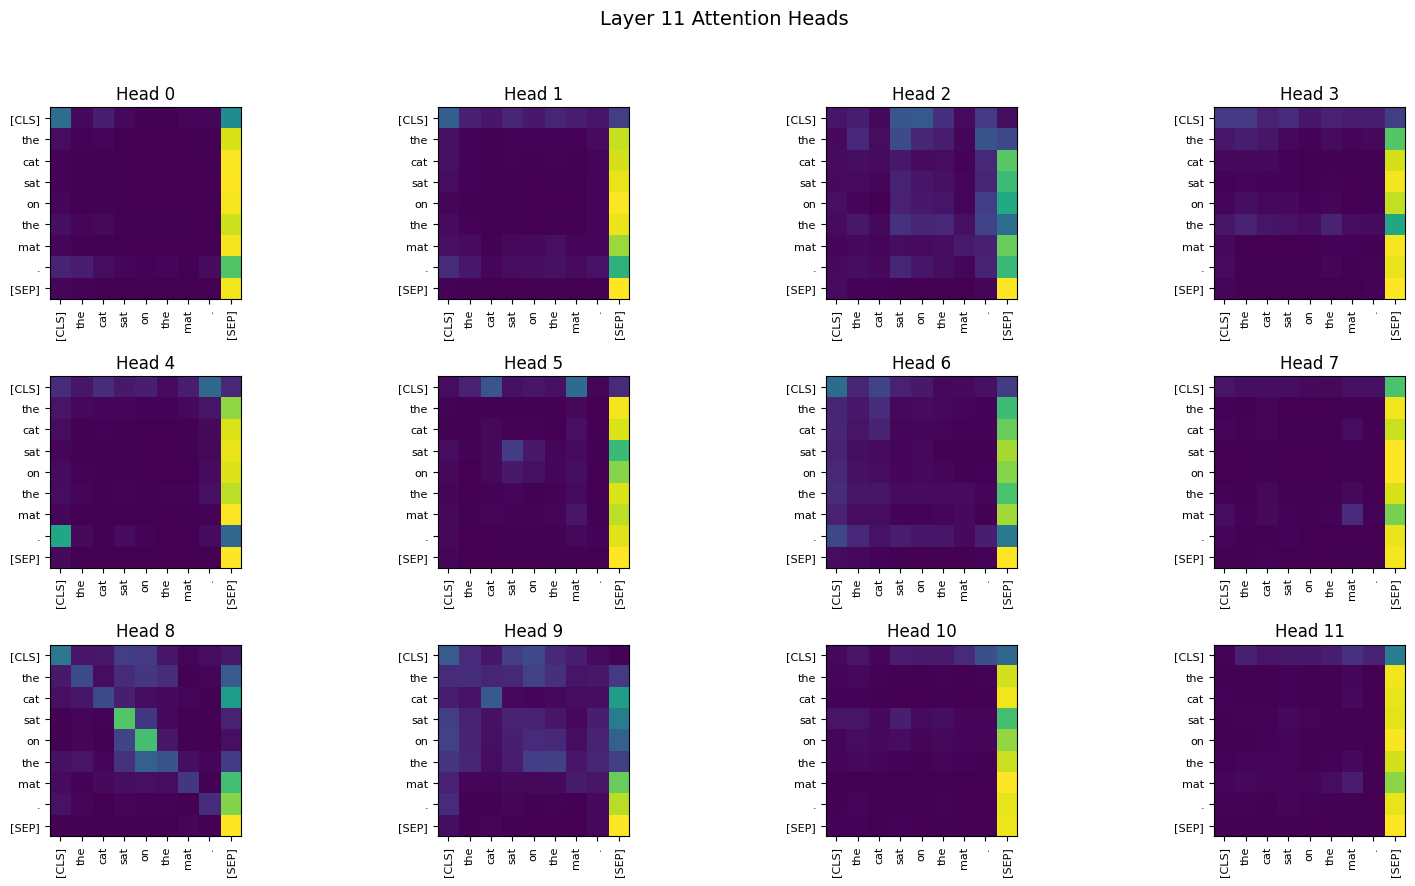

In [7]:
num_layers = len(attentions)
num_heads = attentions[0].shape[1]
seq_len = len(tokens)

# All head and layers iteration
for layer_idx in range(num_layers):
    fig, axs = plt.subplots(3, 4, figsize=(16,9))
    fig.suptitle(f"Layer {layer_idx} Attention Heads", fontsize=14)
    
    for head_idx in range(num_heads):
        attn_matrix = attentions[layer_idx][0, head_idx].detach().numpy()  # (seq_len, seq_len)
        ax = axs[head_idx // 4][head_idx % 4]
        im = ax.imshow(attn_matrix, cmap='viridis')
        ax.set_title(f"Head {head_idx}")
        ax.set_xticks(range(seq_len))
        ax.set_yticks(range(seq_len))
        ax.set_xticklabels(tokens, rotation=90, fontsize=8)
        ax.set_yticklabels(tokens, fontsize=8)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    